In [1]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [2]:
#Fetch Images count from Fodlers

In [2]:
import os

count = 0
dirs = os.listdir('/Users/mbhashyam/Desktop/Project/Flower_recog_Model/Images')
for dir in dirs:
    if not dir.startswith('.'):  # This will skip hidden files like .DS_Store
        files = list(os.listdir('/Users/mbhashyam/Desktop/Project/Flower_recog_Model/Images/' + dir))
        print(dir + ' Folder has ' + str(len(files)) + ' Images')
        count += len(files)

print('Total image count:', count)


daisy Folder has 764 Images
rose Folder has 784 Images
tulip Folder has 984 Images
dandelion Folder has 1052 Images
sunflower Folder has 733 Images
Total image count: 4317


In [3]:
#Load Images into Arrays as Dataset

In [4]:
base_dir = 'Images/'
img_size = 180
batch = 32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [6]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [7]:
import matplotlib.pyplot as plt

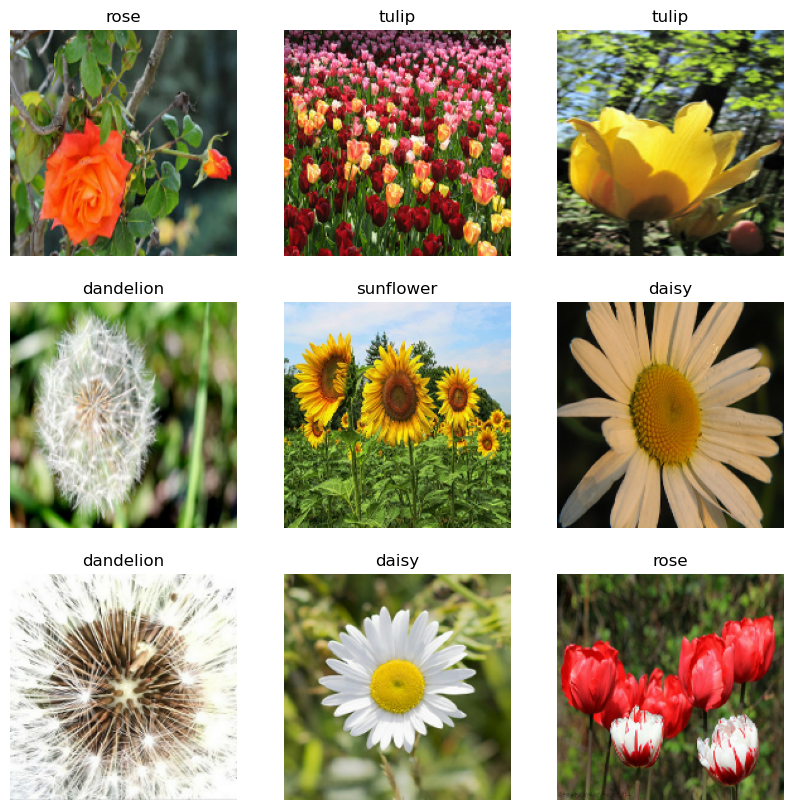

In [8]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [11]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [12]:
#Data Augmentation

In [13]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

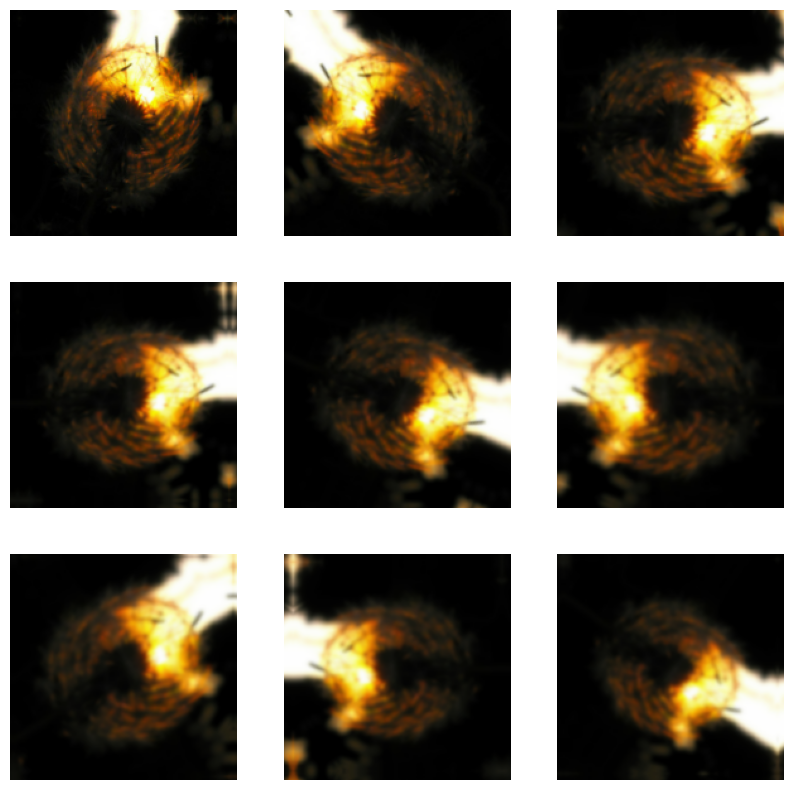

In [14]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [15]:
#MOdel Creation

In [16]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [19]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 [==============================] - 21s 194ms/step - loss: 1.5186 - accuracy: 0.3599 - val_loss: 1.1847 - val_accuracy: 0.5006
Epoch 2/15
108/108 [==============================] - 21s 196ms/step - loss: 1.1142 - accuracy: 0.5533 - val_loss: 1.0350 - val_accuracy: 0.5817
Epoch 3/15
108/108 [==============================] - 21s 197ms/step - loss: 1.0152 - accuracy: 0.6074 - val_loss: 0.9773 - val_accuracy: 0.6141
Epoch 4/15
108/108 [==============================] - 22s 206ms/step - loss: 0.9531 - accuracy: 0.6375 - val_loss: 0.9522 - val_accuracy: 0.6153
Epoch 5/15
108/108 [==============================] - 22s 208ms/step - loss: 0.9119 - accuracy: 0.6506 - val_loss: 0.8992 - val_accuracy: 0.6385
Epoch 6/15
108/108 [==============================] - 22s 203ms/step - loss: 0.8540 - accuracy: 0.6711 - val_loss: 0.9078 - val_accuracy: 0.6501
Epoch 7/15
108/108 [==============================] - 22s 203ms/step - loss: 0.8201 - accuracy: 0.6940 - val_loss: 0.8676 - val_ac

In [20]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [21]:
classify_images('Sample/rose.jpeg')

1/1 [==============================] - 0s 146ms/step


'The Image belongs to rose with a score of 94.66228485107422'

In [22]:
model.save('Flower_Recog_Model.h5')

/Users/mbhashyam/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
